# Librerias 

In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score,roc_curve, confusion_matrix, classification_report
)

# Cargado de datos 

In [2]:
df=pd.read_csv("C:\Documentos\heart-desease-mlops\data\heart.csv",header=0)

In [3]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# Funciones 

In [4]:
def Summary(data, sheet):
    print(f"Hoja: {sheet}")

    # Crear la tabla de resumen
    resumen = {
        "Cantidad de filas": data.shape[0],
        "Cantidad de columnas": data.shape[1],
        "Datos faltantes": data.isnull().sum().sum(),
        "Filas duplicadas": data.duplicated().sum()
    }

    # Convertir el resumen en un DataFrame
    ResumenHoja = pd.DataFrame(resumen, index=["Resumen"])
    print("\nResumen:")
    display(ResumenHoja)

    print("\nEncabezado:")
    display(data.head())

In [5]:
def graficar_distribuciones(df, columnas, bins=30):
    sns.set(style="whitegrid", palette="muted")
    n = len(columnas)
    
    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(12, 4*n))
    
    for i, col in enumerate(columnas):
        # Histograma con KDE
        sns.histplot(data=df, x=col, kde=True, bins=bins, ax=axes[i,0], color="skyblue")
        axes[i,0].set_title(f"Histograma de {col}", fontsize=12)
        axes[i,0].set_xlabel("")
        axes[i,0].set_ylabel("Frecuencia")
        
        # Boxplot
        sns.boxplot(data=df, x=col, ax=axes[i,1], color="lightcoral")
        axes[i,1].set_title(f"Boxplot de {col}", fontsize=12)
        axes[i,1].set_xlabel("")
    
    plt.suptitle("Distribuciones de variables numéricas", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

In [6]:
def graficar_categoricas(df,cat):
    for col  in cat:
        df[col].value_counts()
        sns.countplot(data=df, x=col, order=df[col].value_counts().index)
        plt.title(f'Distribución de {col}')
        plt.xticks(rotation=45)
        plt.show()

In [7]:
def analisis_bivariado_numericas(df, target):
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop(target, errors="ignore")

    for col in num_cols:
        print(f"\n===== Análisis bivariado: {col} vs {target} =====\n")
        
        # Boxplot
        plt.figure(figsize=(6,4))
        sns.boxplot(data=df, x=target, y=col)
        plt.title(f"{col} vs {target} (Boxplot)")
        plt.show()

In [8]:
def analisis_bivariado_categoricas(df, target):
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.drop(target, errors="ignore")

    for col in cat_cols:
        print(f"\n===== Análisis bivariado: {col} vs {target} =====\n")
        tabla = pd.crosstab(df[col], df[target])
        print("Frecuencias absolutas:\n", tabla)
        print("\nFrecuencias relativas (%):\n", 
              tabla.div(tabla.sum(axis=1), axis=0).round(2))
        plt.figure(figsize=(6,4))
        sns.countplot(data=df, x=col, hue=target)
        plt.title(f"{col} vs {target}")
        plt.xticks(rotation=30)
        plt.show()
        plt.figure(figsize=(6,4))
        sns.heatmap(tabla, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Heatmap {col} vs {target}")
        plt.show()

In [9]:
def run_gridsearch(pipe, model, param_grid, X_train, y_train, scoring="roc_auc", cv=5):
    grid = GridSearchCV(
        pipe.set_params(model=model),
        param_grid,
        cv=cv,
        scoring=scoring
    )
    grid.fit(X_train, y_train)
    return grid

In [10]:
def plot_histograms(var, bins=20):
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    
    # Original
    axes[0].hist(df[var].dropna(), bins=bins, color="skyblue", edgecolor="black")
    axes[0].set_title(f"{var} - Original")
    
    # Buscar nombre correcto en transformados
    col_imputed = [c for c in df_imputed.columns if var in c][0]
    
    # Imputado
    axes[1].hist(df_imputed[col_imputed], bins=bins, color="lightgreen", edgecolor="black")
    axes[1].set_title(f"{var} - Imputado")
    plt.tight_layout()
    plt.show()

In [11]:
def evaluar_imputacion_columnas(df_original, df_imputado, columnas, alpha=0.05):
    resultados = []

    for var in columnas:
        # Verificar que la columna existe en el original
        if var not in df_original.columns:
            resultados.append({
                "variable": var,
                "error": "Columna no encontrada en df_original"
            })
            continue

        # Buscar nombre correspondiente en df_imputed
        posibles = [c for c in df_imputado.columns if var in c]
        if not posibles:
            resultados.append({
                "variable": var,
                "error": "Columna no encontrada en df_imputed"
            })
            continue

        col_imp = posibles[0]  # Usa el primero que coincida

        # Extraer columnas sin nulos
        orig_col = df_original[var].dropna()
        imp_col = df_imputado[col_imp].dropna()

        if len(orig_col) < 3 or len(imp_col) < 3:
            resultados.append({
                "variable": var,
                "columna_imputada": col_imp,
                "error": "No hay suficientes datos para comparar"
            })
            continue

        # Normalidad
        try:
            p_norm_orig = stats.shapiro(orig_col).pvalue
            p_norm_imp = stats.shapiro(imp_col).pvalue
            es_normal = (p_norm_orig > alpha) and (p_norm_imp > alpha)
        except:
            p_norm_orig = p_norm_imp = np.nan
            es_normal = False

        # Test
        if es_normal:
            test = "t-test"
            stat, p_valor = stats.ttest_ind(orig_col, imp_col, equal_var=False)
        else:
            test = "Mann-Whitney"
            stat, p_valor = stats.mannwhitneyu(orig_col, imp_col, alternative='two-sided')

        resultados.append({
            "variable": var,
            "columna_imputada": col_imp,
            "normalidad_original_p": p_norm_orig,
            "normalidad_imputado_p": p_norm_imp,
            "test_usado": test,
            "p_valor": p_valor,
            "diferencia_significativa": p_valor < alpha
        })

    return pd.DataFrame(resultados)

In [12]:
def evaluar_modelo(model, X_test, y_test):
    # Predicciones
    y_pred = model.predict(X_test)
    
    # Algunas métricas necesitan probabilidades (si están disponibles)
    try:
        y_proba = model.predict_proba(X_test)[:,1]
        auc = roc_auc_score(
            y_test, y_proba
        )
    except:
        auc = None
    
    # Resultados
    resultados = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "ROC-AUC": auc,
        "Confusion Matrix": confusion_matrix(y_test, y_pred),
        "Classification Report": classification_report(y_test, y_pred)
    }
    
    return resultados

In [13]:
def graficar_curva_roc(model, X_test, y_test):
    try:
        # Probabilidades del modelo
        y_proba = model.predict_proba(X_test)[:, 1]
    except:
        print("⚠️ El modelo no soporta 'predict_proba'. No se puede graficar la curva ROC.")
        return
    
    # Calcular puntos de la curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)

    # Graficar
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, label=f"Modelo (AUC = {auc:.2f})", color="blue", linewidth=2)
    plt.plot([0, 1], [0, 1], "k--", label="Azar")
    plt.xlabel("Tasa de Falsos Positivos (FPR)")
    plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
    plt.title("Curva ROC")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

# Analisis Exploratorio de datos 

In [14]:
Summary(df,'df')

Hoja: df

Resumen:


,Cantidad de filas,Cantidad de columnas,Datos faltantes,Filas duplicadas
Resumen,918,12,0,0



Encabezado:


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


# Analisis Univariado 

## Analisis Univariado numericas 

In [16]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [17]:
num=["Age","RestingBP","Cholesterol","FastingBS","MaxHR","Oldpeak"]

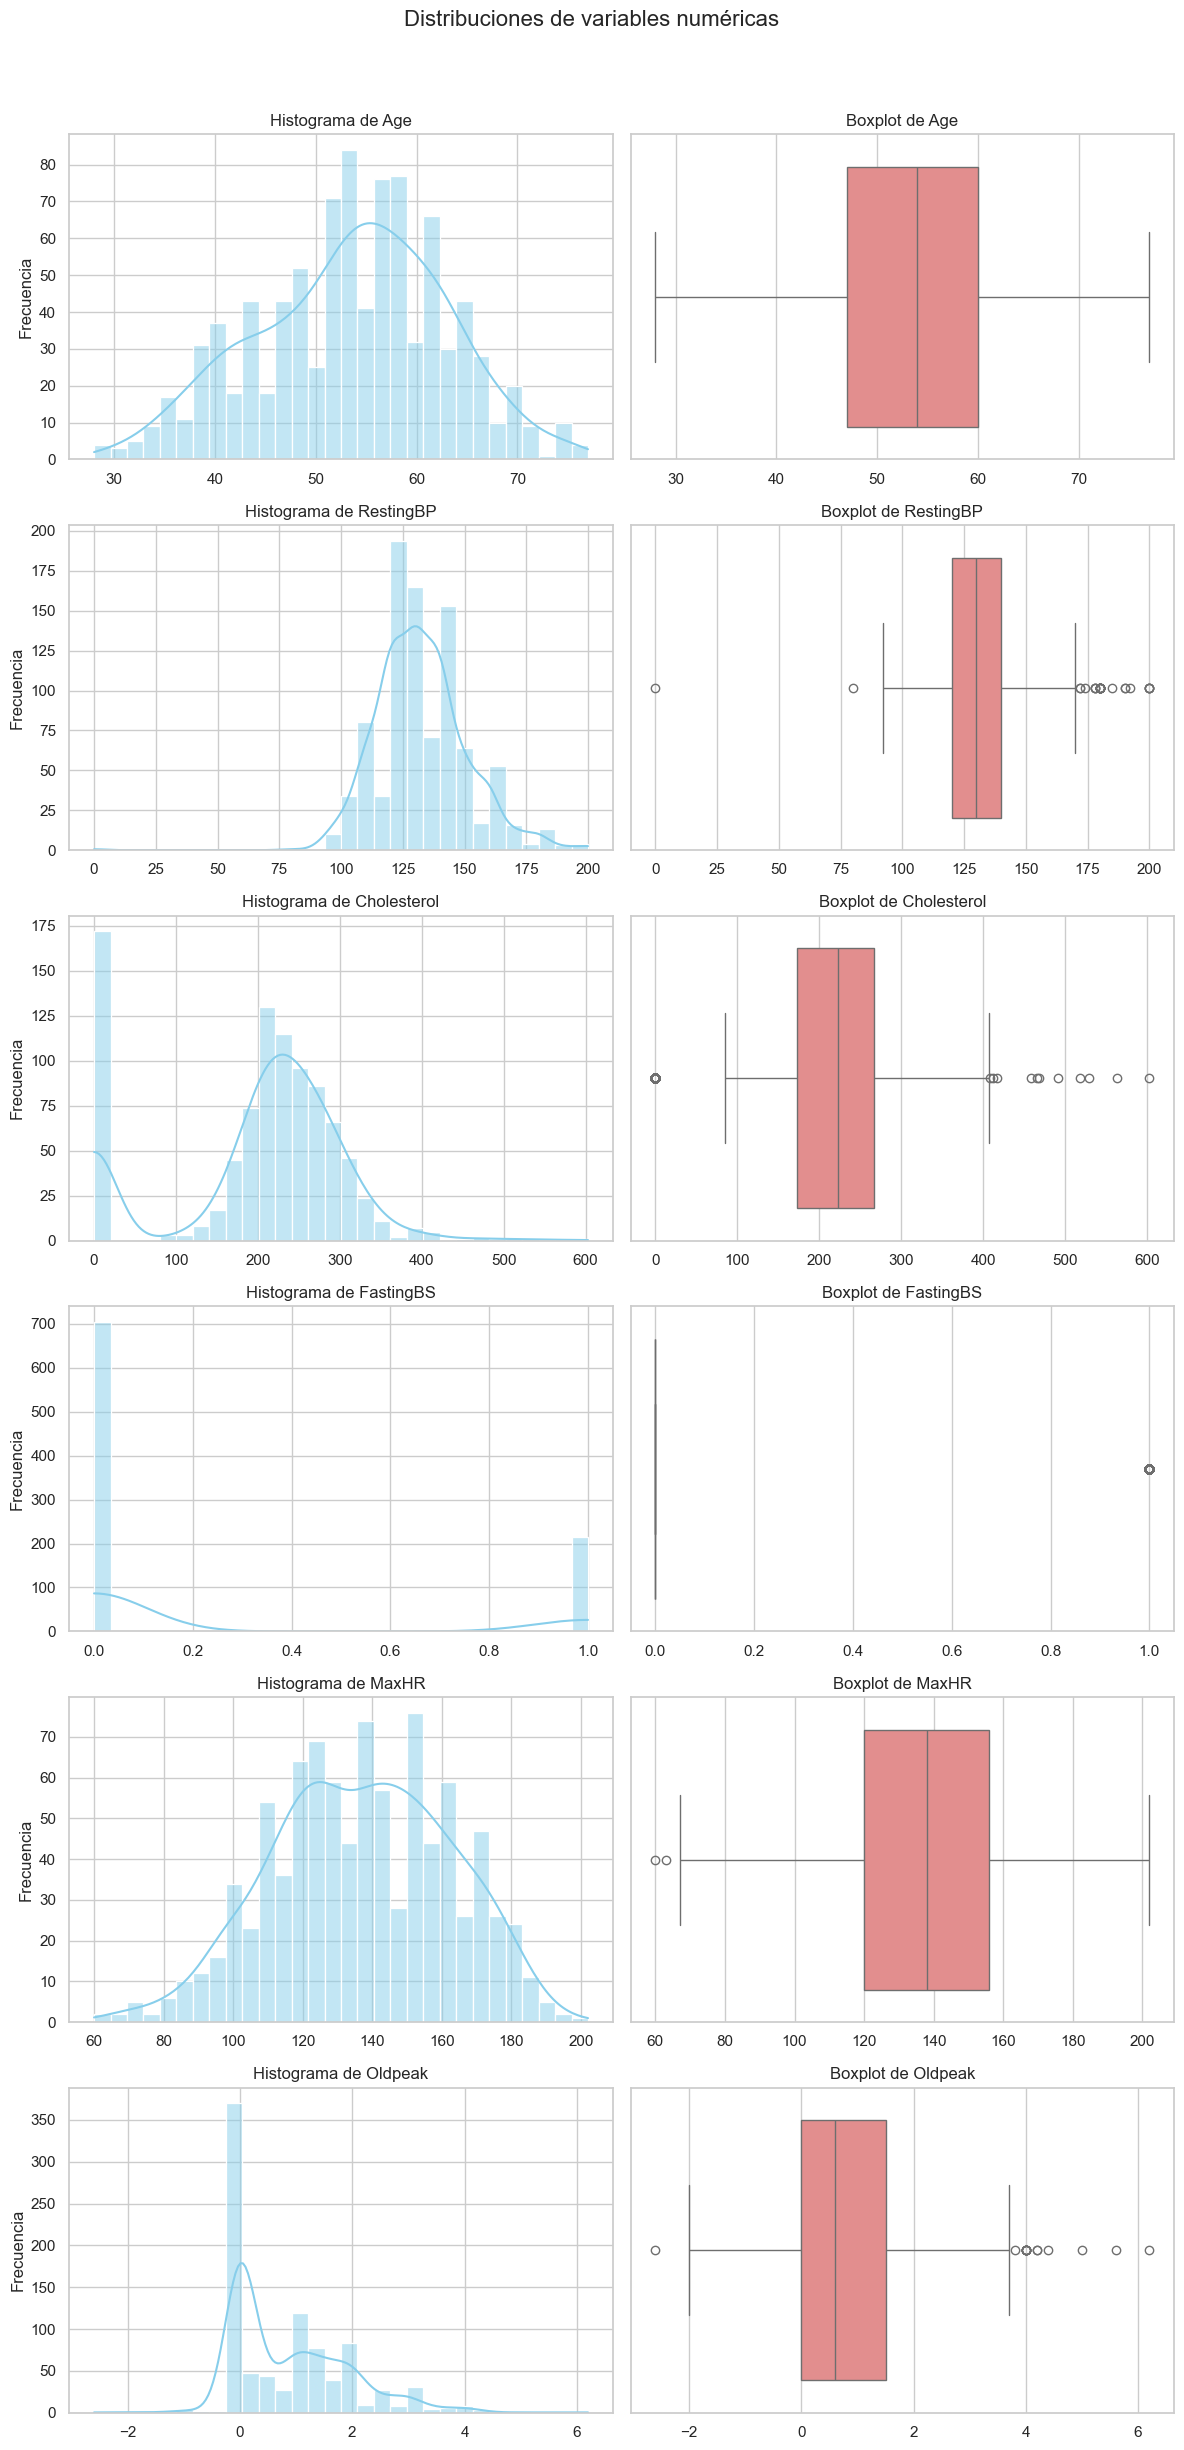

In [18]:
graficar_distribuciones(df,num)

Podemos observar que en algunas variables hay una gran cantidad de valores 0 como en colesterol o RestingBP los cuales no son valores realistas por lo que los vamos a tomar como NA para imputarlos despues. Lo mismo ocurre con los valores excesivamente altos de colesterol, los cuales vamos a winzorizar 

In [19]:
cols_outliers_bajos = ["Cholesterol", "RestingBP"]
df[cols_outliers_bajos] = df[cols_outliers_bajos].replace(0, np.nan)

In [20]:
df['Cholesterol'] = df['Cholesterol'].clip(upper=400)

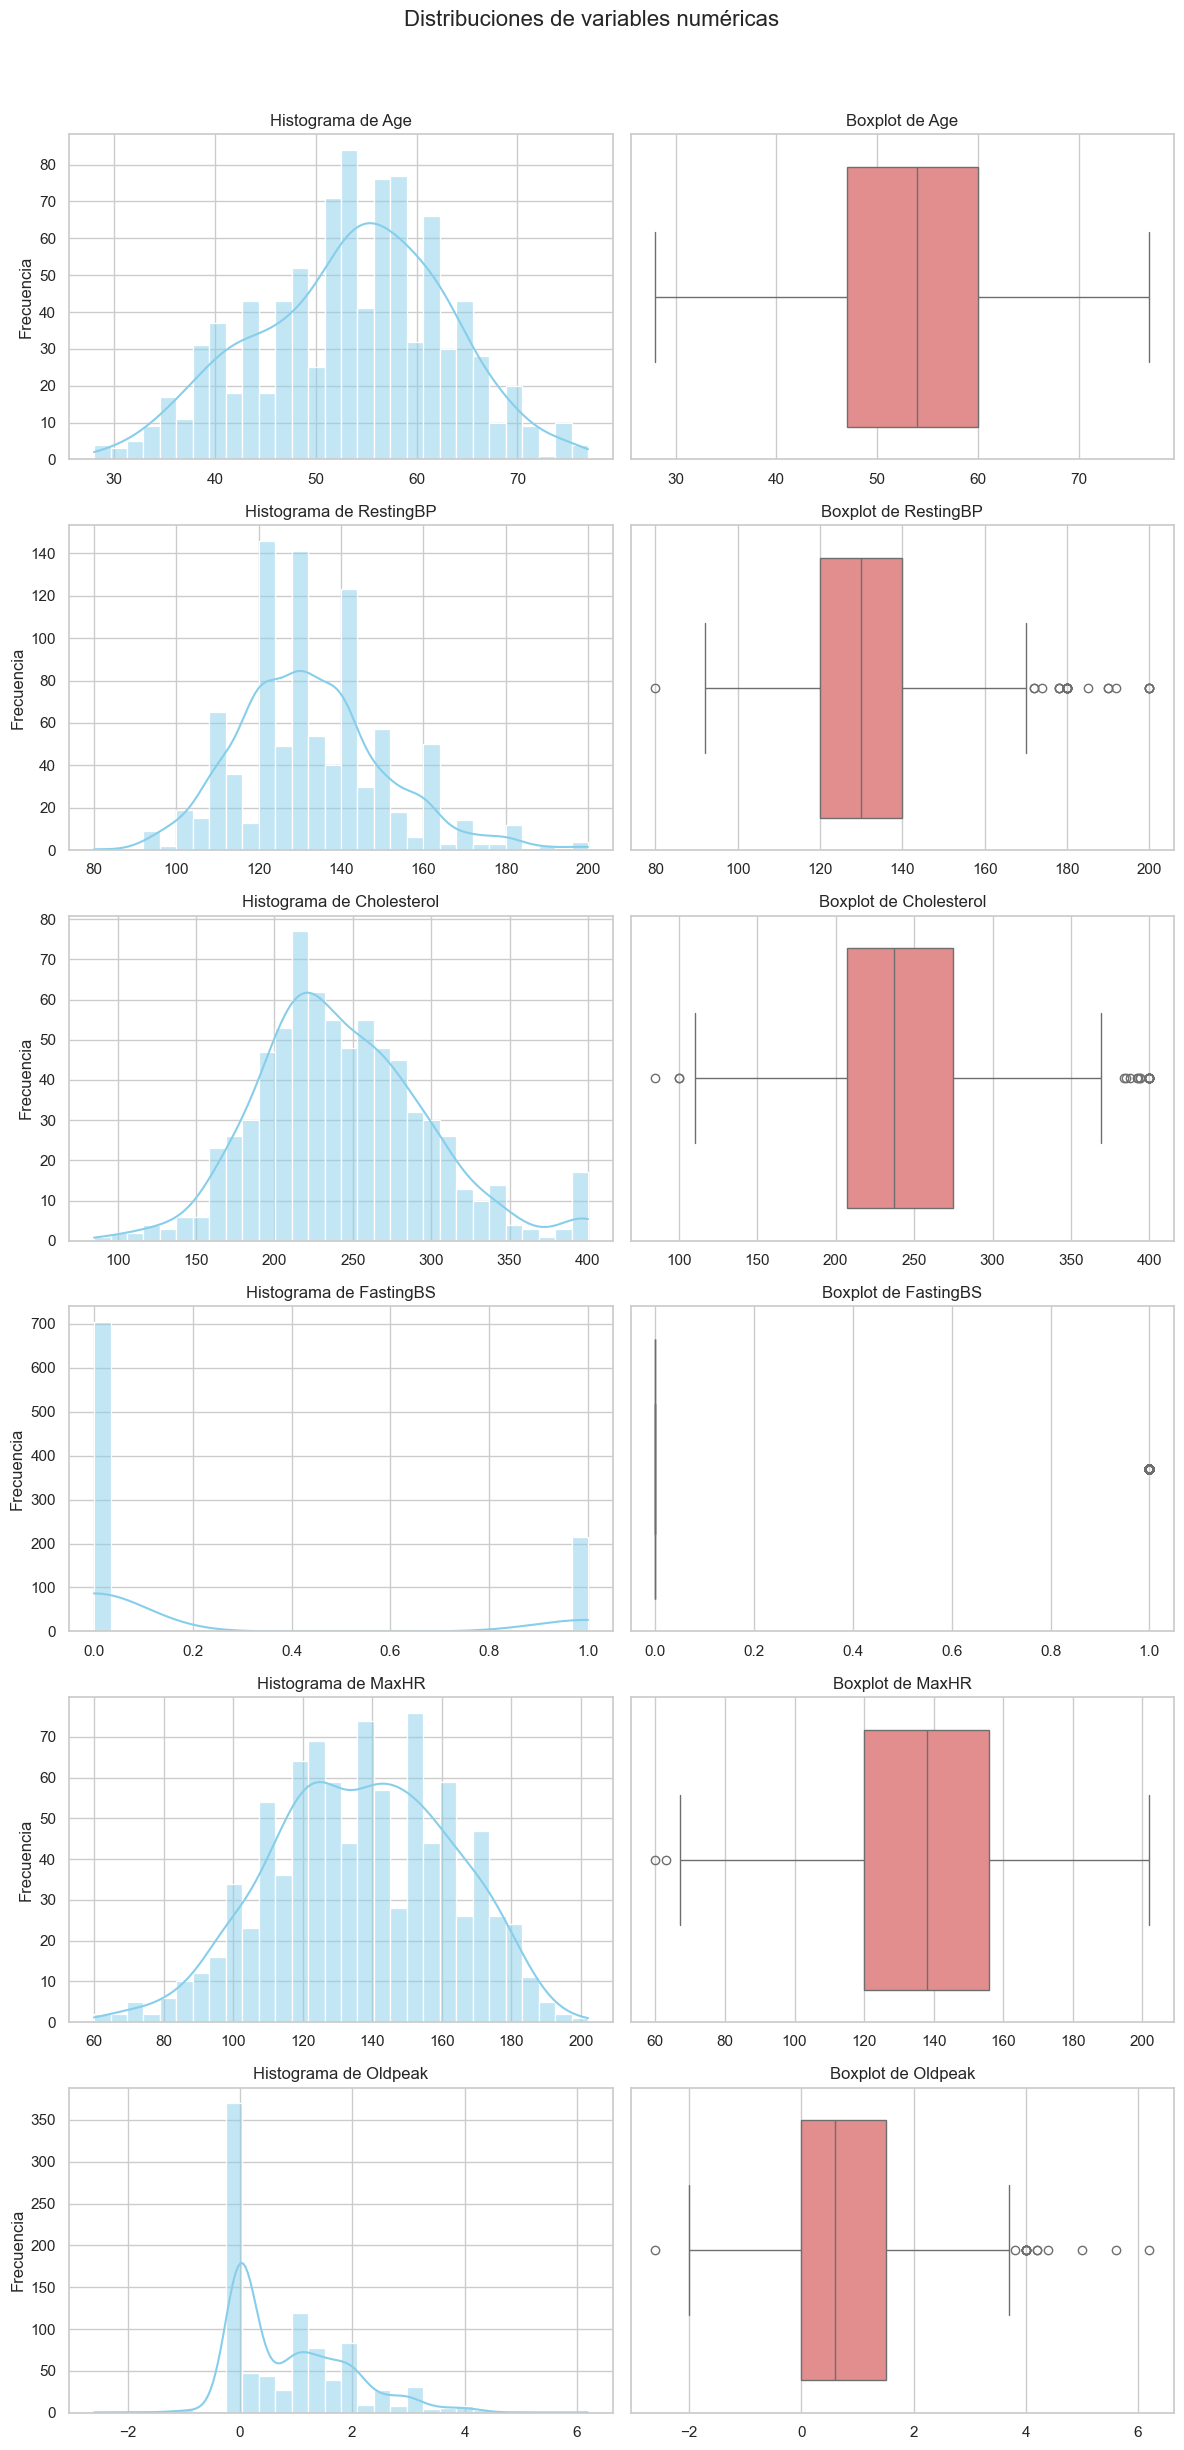

In [21]:
graficar_distribuciones(df,num)

## Analisis univariado categoricas 

In [22]:
categoricas=["Sex","ChestPainType","RestingECG","ExerciseAngina","ST_Slope"]

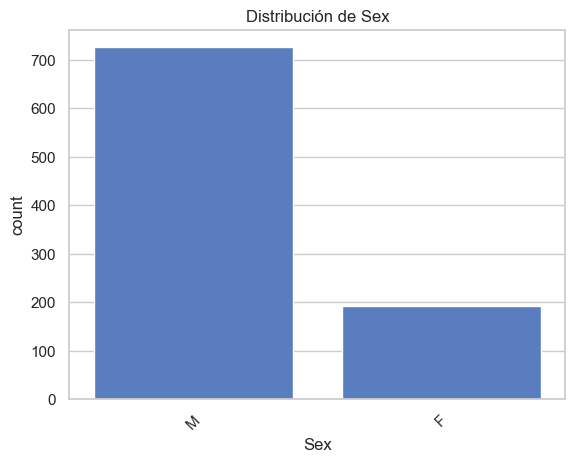

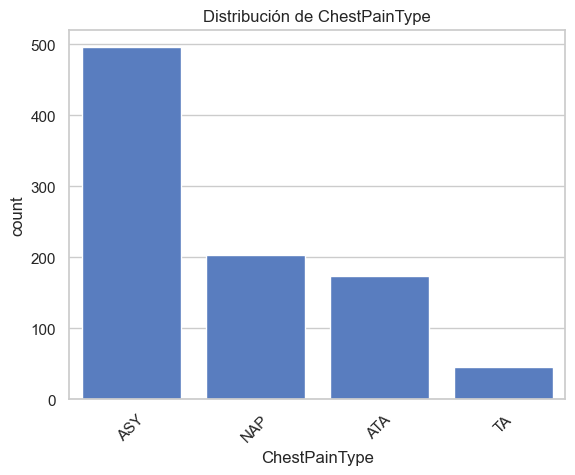

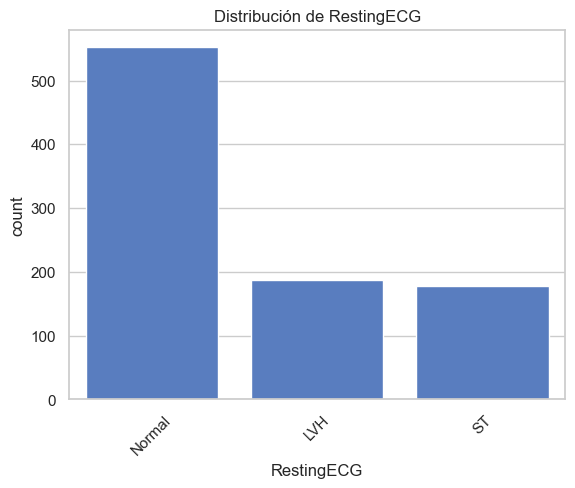

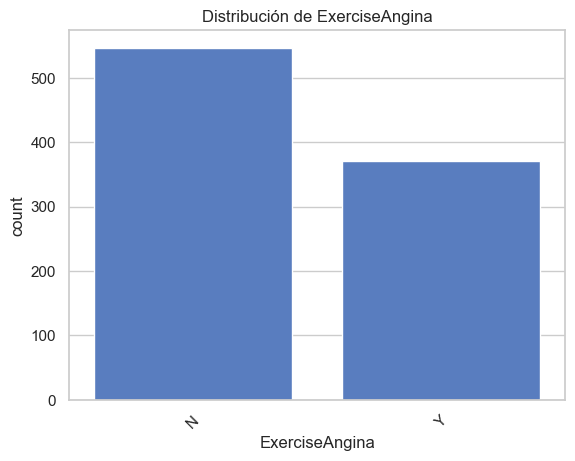

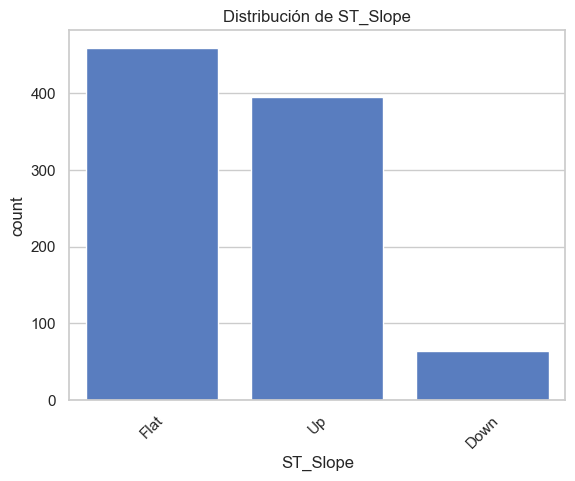

In [23]:
graficar_categoricas(df,categoricas)

Revisamos la distribucion de la variable objetivo

In [24]:
df['HeartDisease'].value_counts()

HeartDisease
1    508
0    410
Name: count, dtype: int64

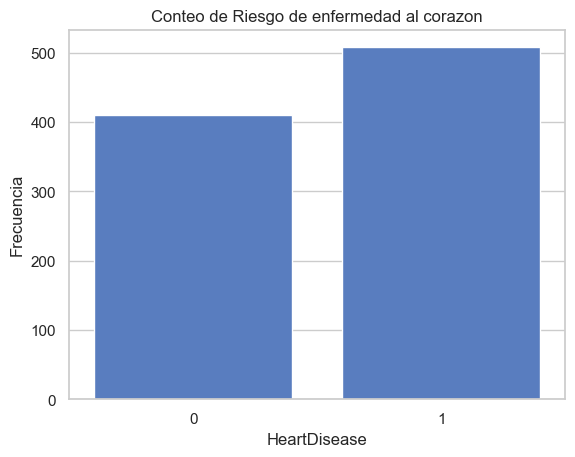

In [25]:
plt.title('Conteo de Riesgo de enfermedad al corazon')
sns.countplot(x=df.HeartDisease)
plt.xlabel('HeartDisease')
plt.ylabel('Frecuencia')
plt.show()

Podemos observar que no hay un desbalance tan severo entre las clases por lo que no debemos realizar algun tipo de balanceo despues durante el preprocesamiento

## Analisis Bivariado de Numericas 


===== Análisis bivariado: Age vs HeartDisease =====



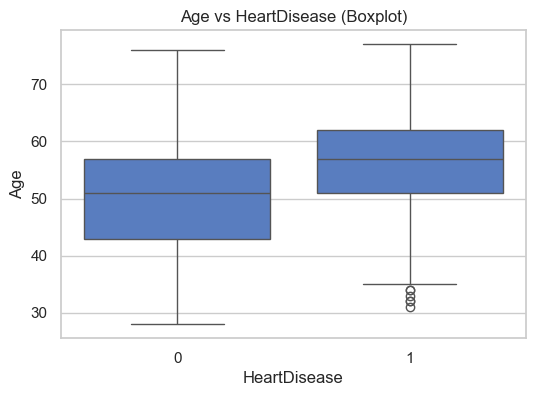


===== Análisis bivariado: RestingBP vs HeartDisease =====



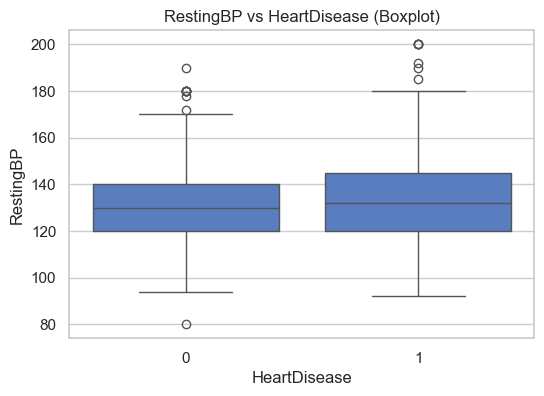


===== Análisis bivariado: Cholesterol vs HeartDisease =====



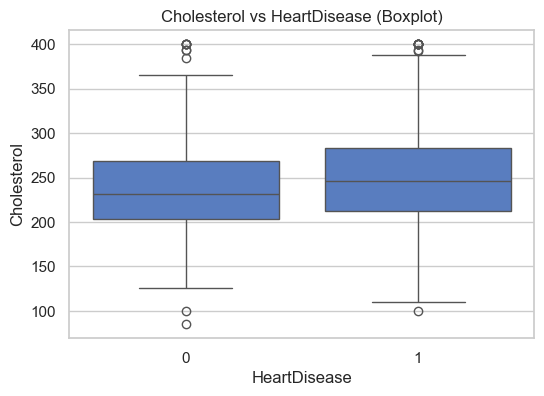


===== Análisis bivariado: FastingBS vs HeartDisease =====



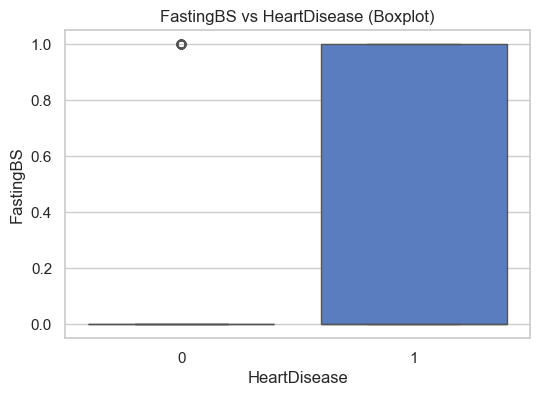


===== Análisis bivariado: MaxHR vs HeartDisease =====



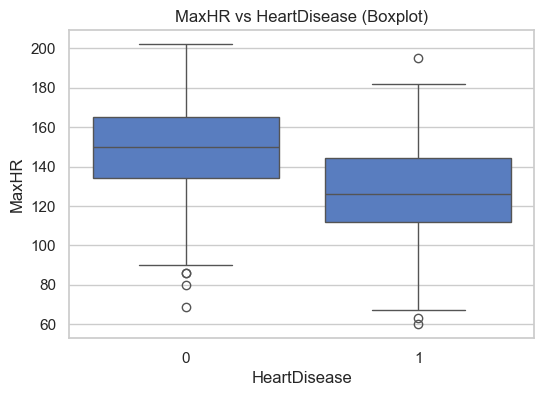


===== Análisis bivariado: Oldpeak vs HeartDisease =====



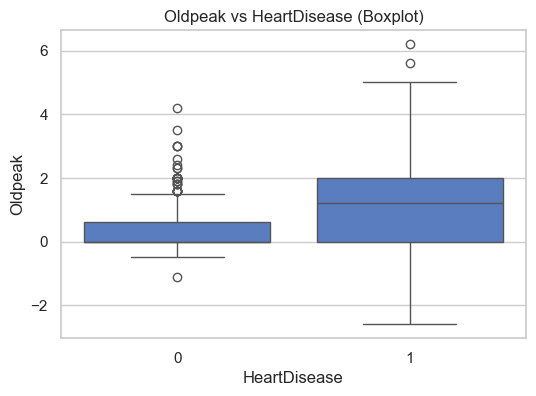

In [26]:
analisis_bivariado_numericas(df,target='HeartDisease')

In [27]:
corr_num=df[num].corr()

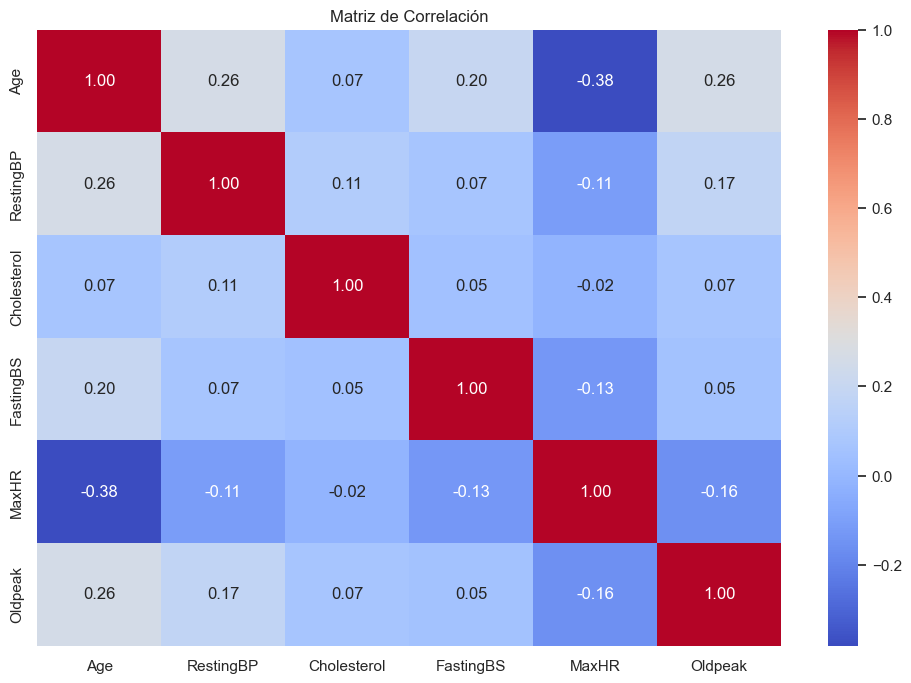

In [28]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_num, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

Podemos observar que tienen bajas correlaciones las variables numericas entre si

## Analisis Bivariado de Categoricas 


===== Análisis bivariado: Sex vs HeartDisease =====

Frecuencias absolutas:
 HeartDisease    0    1
Sex                   
F             143   50
M             267  458

Frecuencias relativas (%):
 HeartDisease     0     1
Sex                     
F             0.74  0.26
M             0.37  0.63


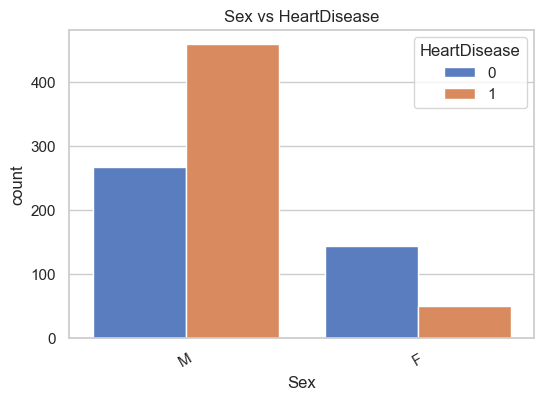

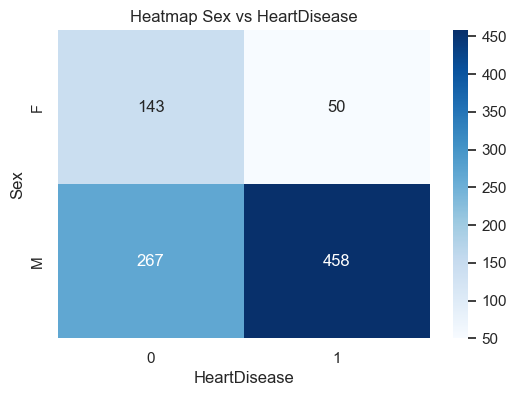


===== Análisis bivariado: ChestPainType vs HeartDisease =====

Frecuencias absolutas:
 HeartDisease     0    1
ChestPainType          
ASY            104  392
ATA            149   24
NAP            131   72
TA              26   20

Frecuencias relativas (%):
 HeartDisease      0     1
ChestPainType            
ASY            0.21  0.79
ATA            0.86  0.14
NAP            0.65  0.35
TA             0.57  0.43


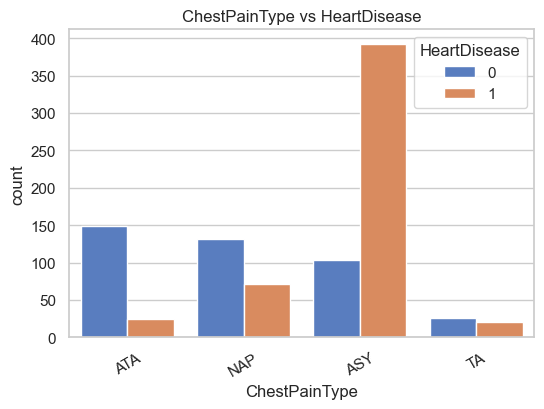

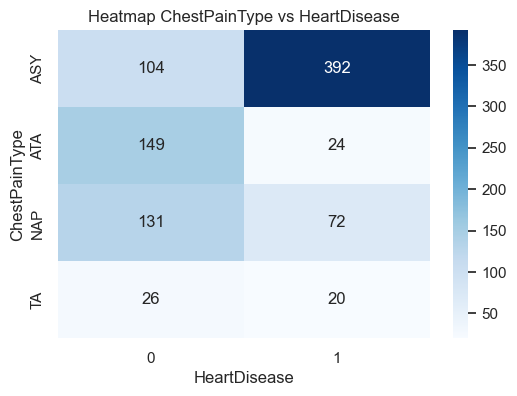


===== Análisis bivariado: RestingECG vs HeartDisease =====

Frecuencias absolutas:
 HeartDisease    0    1
RestingECG            
LVH            82  106
Normal        267  285
ST             61  117

Frecuencias relativas (%):
 HeartDisease     0     1
RestingECG              
LVH           0.44  0.56
Normal        0.48  0.52
ST            0.34  0.66


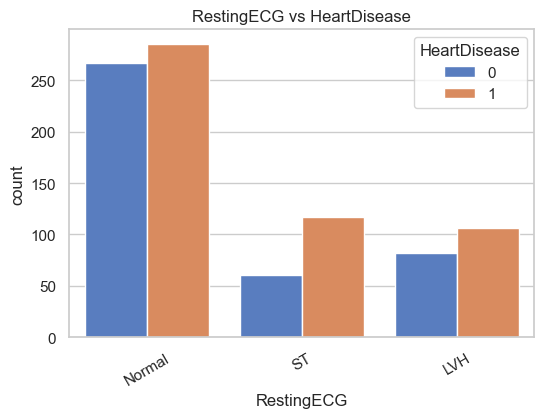

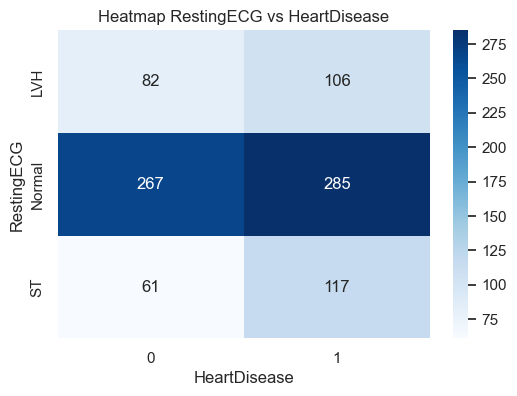


===== Análisis bivariado: ExerciseAngina vs HeartDisease =====

Frecuencias absolutas:
 HeartDisease      0    1
ExerciseAngina          
N               355  192
Y                55  316

Frecuencias relativas (%):
 HeartDisease       0     1
ExerciseAngina            
N               0.65  0.35
Y               0.15  0.85


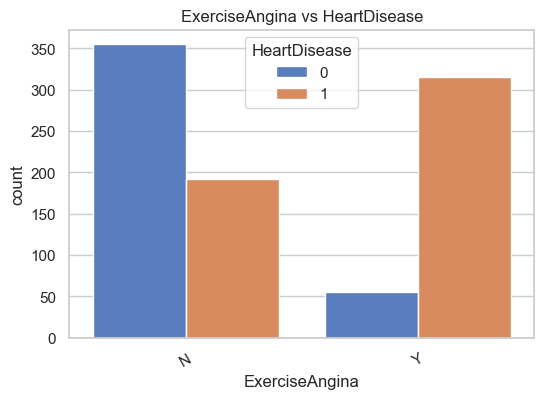

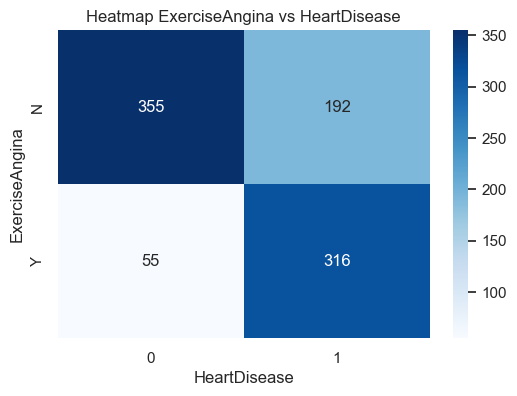


===== Análisis bivariado: ST_Slope vs HeartDisease =====

Frecuencias absolutas:
 HeartDisease    0    1
ST_Slope              
Down           14   49
Flat           79  381
Up            317   78

Frecuencias relativas (%):
 HeartDisease     0     1
ST_Slope                
Down          0.22  0.78
Flat          0.17  0.83
Up            0.80  0.20


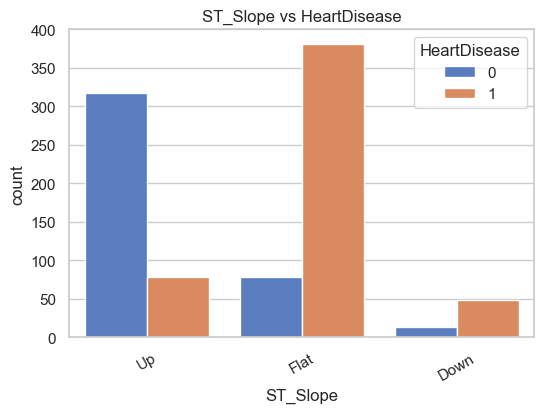

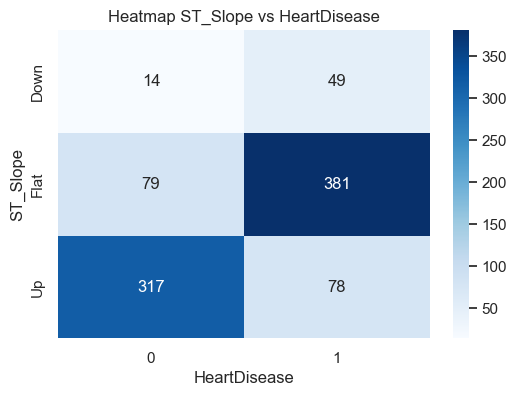

In [29]:
analisis_bivariado_categoricas(df,target='HeartDisease')

revisamos tambien el numero de valores faltantes

In [30]:
porcentaje=df.isna().sum() / len(df) * 100
print(porcentaje.to_string())

Age                0.000000
Sex                0.000000
ChestPainType      0.000000
RestingBP          0.108932
Cholesterol       18.736383
FastingBS          0.000000
RestingECG         0.000000
MaxHR              0.000000
ExerciseAngina     0.000000
Oldpeak            0.000000
ST_Slope           0.000000
HeartDisease       0.000000


Podemos observar que Cholesterol tiene un gran numero de faltantes por lo que se tendra en cuenta par el preprocesamiento

# Preprocesamiento

## Split de los datos

In [31]:
X=df.drop(columns=['HeartDisease'])
y=df['HeartDisease']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [33]:
print(X_test)

     Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
306   55   M           ASY      115.0          NaN          1     Normal   
711   66   M           ASY      120.0        302.0          0        LVH   
298   51   M           ASY      110.0          NaN          1     Normal   
466   55   M           NAP      120.0          NaN          0         ST   
253   62   M           ATA      140.0        271.0          0     Normal   
..   ...  ..           ...        ...          ...        ...        ...   
909   63   F           ASY      124.0        197.0          0     Normal   
293   65   M           ASY      115.0          NaN          0     Normal   
761   52   M           ASY      112.0        230.0          0     Normal   
2     37   M           ATA      130.0        283.0          0         ST   
409   53   M           NAP      160.0          NaN          1        LVH   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  
306    155              N      0.1     Fl

## Creacion de Pipelines

Se crean los pipelines para variables numericas y categoricas 

In [34]:
todas_numericas = X_train.select_dtypes(include="int64").columns.tolist()

In [35]:
median_vars = ["RestingBP"]
knn_vars = ["Cholesterol"]

In [36]:
numericas = list(set(todas_numericas) - set(median_vars) - set(knn_vars))

In [37]:
# Transformers
median_imputer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

knn_imputer = Pipeline(steps=[
    ("imputer", KNNImputer(n_neighbors=3))
])

In [38]:
Pipe_cat = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
])

In [39]:
Pipe_num = Pipeline(steps=[
    ("scaler", StandardScaler())
])

In [40]:
imputation = ColumnTransformer(transformers=[
    ("median_vars", median_imputer, median_vars),
    ("knn_vars", knn_imputer, knn_vars),
    ("cat_vars", Pipe_cat, categoricas),
    ("passthrough", Pipe_num, numericas)
])

In [41]:
preprocesamiento = ColumnTransformer(transformers=[
    ("median_vars", Pipeline([
        ("imputer", median_imputer),
        ("scaler", StandardScaler())
    ]), median_vars),
    
    ("knn_vars", Pipeline([
        ("imputer", knn_imputer),
        ("scaler", StandardScaler())
    ]), knn_vars),
    
    ("cat_vars", Pipe_cat, categoricas),
    ("passthrough", Pipe_num, numericas)
])

In [42]:
pipe = Pipeline(steps=[
    ("preprocessor", preprocesamiento),
    ("model", LogisticRegression())  
])

In [43]:
output_imputed = imputation.fit_transform(X_train)
column_names_imputed = imputation.get_feature_names_out()

df_imputed = pd.DataFrame(output_imputed, columns=column_names_imputed)

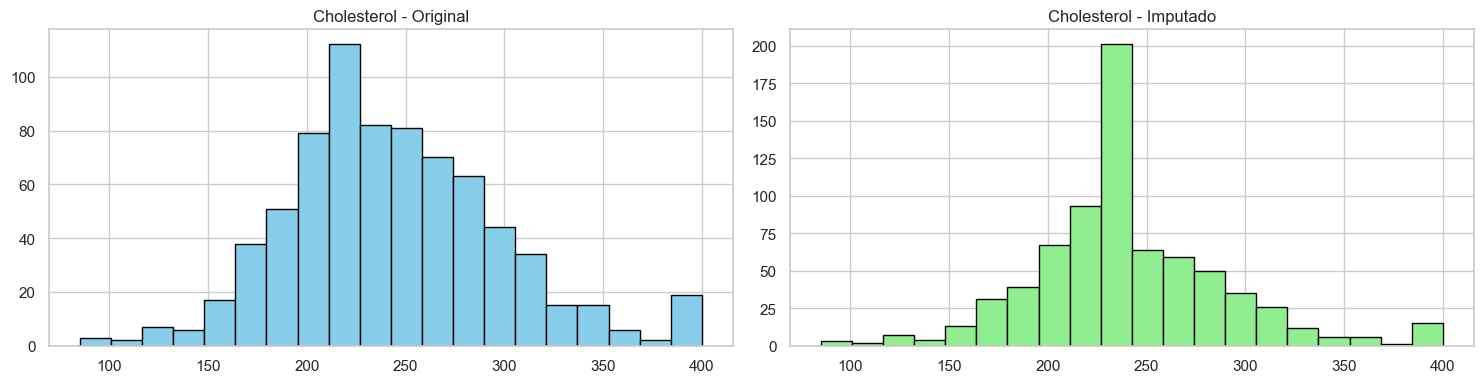

In [44]:
plot_histograms('Cholesterol')

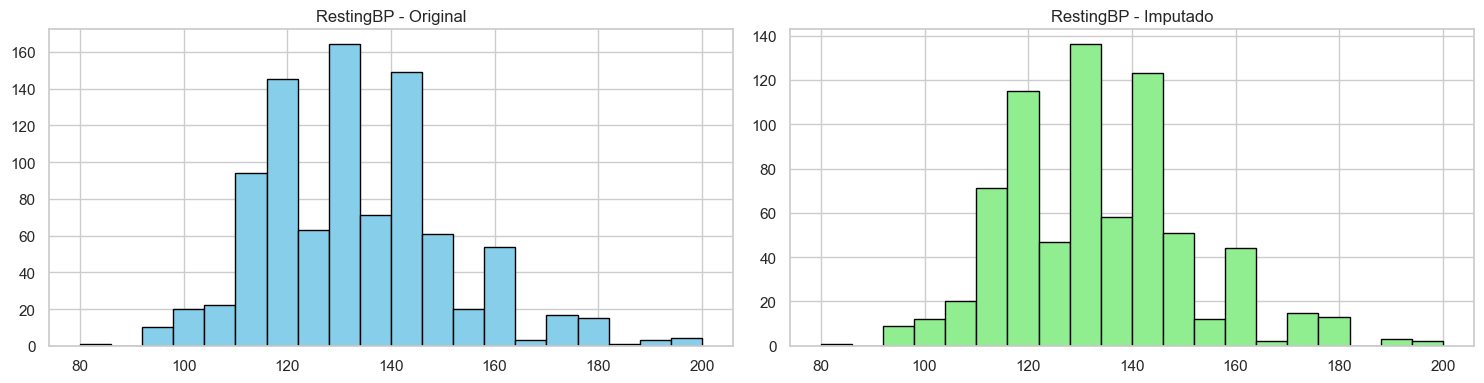

In [45]:
plot_histograms('RestingBP')

In [46]:
imput_cols=['RestingBP','Cholesterol']

In [47]:
resultados=evaluar_imputacion_columnas(df,df_imputed,imput_cols)
print(resultados)

      variable        columna_imputada  normalidad_original_p  \
0    RestingBP  median_vars__RestingBP           1.792139e-12   
1  Cholesterol   knn_vars__Cholesterol           3.519109e-08   

   normalidad_imputado_p    test_usado   p_valor  diferencia_significativa  
0           1.876145e-10  Mann-Whitney  0.770192                     False  
1           5.142175e-13  Mann-Whitney  0.932453                     False  


Por lo tanto las imputaciones se realizaron con exito

Revisamos la multicolinealidad 

In [48]:
# 1. Transformar X_train con el preprocesador
X_train_transformed = pipe.named_steps["preprocessor"].fit_transform(X_train)

# 2. Obtener nombres de las columnas
feature_names = pipe.named_steps["preprocessor"].get_feature_names_out()

# 3. Convertir a DataFrame
X_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)

In [49]:
vif_data = pd.DataFrame()
vif_data["Variable"] = X_transformed_df.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_transformed_df.values, i)
    for i in range(X_transformed_df.shape[1])
]

print(vif_data.sort_values("VIF", ascending=False))

                       Variable       VIF
2               cat_vars__Sex_M  4.293119
10        cat_vars__ST_Slope_Up  4.210282
9       cat_vars__ST_Slope_Flat  4.159164
6   cat_vars__RestingECG_Normal  3.928156
8    cat_vars__ExerciseAngina_Y  2.356759
7       cat_vars__RestingECG_ST  2.030131
3   cat_vars__ChestPainType_ATA  1.775763
4   cat_vars__ChestPainType_NAP  1.569793
11           passthrough__MaxHR  1.541293
12             passthrough__Age  1.399053
5    cat_vars__ChestPainType_TA  1.158428
0        median_vars__RestingBP  1.115409
13       passthrough__FastingBS  1.113214
1         knn_vars__Cholesterol  1.058671


In [ ]:
X_transformed_df.to_csv("data\processed/X_train.csv", index=False)
X_test.to_csv("data\processed/X_test.csv", index=False)

# Modelos con Gridsearch

In [ ]:
param_grid_lr = {
    "model__C": [0.01, 0.1, 1, 10,100],
    "model__solver": ["lbfgs","saga"]
}

In [ ]:
grid_lr = run_gridsearch(
    pipe,
    LogisticRegression(max_iter=1000, random_state=0),
    param_grid_lr,
    X_train,
    y_train
)

In [ ]:
print("Best LR params:", grid_lr.best_params_)
print("Best LR CV score:", grid_lr.best_score_)

Best LR params: {'model__C': 1, 'model__solver': 'lbfgs'}
Best LR CV score: 0.9250223419937351


In [ ]:
param_grid_knn = {
    "model__n_neighbors": range(1,21)
}

In [ ]:
grid_knn = run_gridsearch(
    pipe,
    KNeighborsClassifier(),
    param_grid_knn,
    X_train,
    y_train
)

In [ ]:
print("Best KNN params:", grid_knn.best_params_)
print("Best KNN CV score:", grid_knn.best_score_)

Best KNN params: {'model__n_neighbors': 11}
Best KNN CV score: 0.9092355701849899


In [ ]:
grid_ridge = run_gridsearch(
    pipe,
    LogisticRegression(max_iter=1000, random_state=0,penalty='l2'),
    param_grid_lr,
    X_train,
    y_train
)

In [ ]:
print("Best Ridge params:", grid_ridge.best_params_)
print("Best Ridge CV score:", grid_ridge.best_score_)

Best Ridge params: {'model__C': 1, 'model__solver': 'lbfgs'}
Best Ridge CV score: 0.9250223419937351


In [ ]:
param_grid_lasso = {
    "model__C": [0.01, 0.1, 1, 10,100],
}

In [ ]:
grid_lasso = run_gridsearch(
    pipe,
    LogisticRegression(max_iter=1000, random_state=0,penalty='l1',solver='saga'),
    param_grid_lasso,
    X_train,
    y_train
)

In [ ]:
print("Best Lasso params:", grid_lasso.best_params_)
print("Best Lasso CV score:", grid_lasso.best_score_)

Best Lasso params: {'model__C': 1}
Best Lasso CV score: 0.9245343638150437


In [ ]:
param_nb = {
    "model__var_smoothing": np.logspace(-9, -3, 7)  
}

In [ ]:
grid_Bayes = run_gridsearch(
    pipe,
    GaussianNB(),
    param_nb,
    X_train,
    y_train
)

In [ ]:
print("Best Bayes params:", grid_Bayes.best_params_)
print("Best Bayes CV score:", grid_Bayes.best_score_)

Best Bayes params: {'model__var_smoothing': np.float64(0.001)}
Best Bayes CV score: 0.9198705336951605


In [ ]:
param_rf = {
    "model__n_estimators": [10,50,100],
    "model__max_depth": [5,10,15]
}

In [ ]:
grid_RF = run_gridsearch(
    pipe,
    RandomForestClassifier(random_state=0),
    param_rf,
    X_train,
    y_train
)

In [ ]:
print("Best RandomForest params:", grid_RF.best_params_)
print("Best RandomForest CV score:", grid_RF.best_score_)

Best RandomForest params: {'model__max_depth': 5, 'model__n_estimators': 100}
Best RandomForest CV score: 0.9215820797806702


In [ ]:
param_gb = {
    "model__n_estimators": [50, 100],         
    "model__learning_rate": [0.05, 0.1],      
    "model__max_depth": [3, 5],               
    "model__subsample": [0.8, 1.0]            
}

In [ ]:
grid_gr = run_gridsearch(
    pipe,
    GradientBoostingClassifier(random_state=0),
    param_gb,
    X_train,
    y_train
)

In [ ]:
print("Best GradientBoosting params:", grid_gr.best_params_)
print("Best GradientBoosting CV score:", grid_gr.best_score_)

Best GradientBoosting params: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 0.8}
Best GradientBoosting CV score: 0.9225389815791972


In [ ]:
param_xgb = {
    "model__n_estimators": [50, 100],         
    "model__learning_rate": [0.05, 0.1],      
    "model__max_depth": [3, 5],               
    "model__subsample": [0.8, 1.0],           
    "model__colsample_bytree": [0.8, 1.0]     
}

In [ ]:
grid_xg = run_gridsearch(
    pipe,
    XGBClassifier(random_state=0,eval_metric="logloss"),
    param_xgb,
    X_train,
    y_train
)

In [ ]:
print("Best XGBoost params:", grid_xg.best_params_)
print("Best XGBoost CV score:", grid_xg.best_score_)

Best XGBoost params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 0.8}
Best XGBoost CV score: 0.9291520511918521


# Evaluacion de metricas 

In [ ]:
mejor_modelo_lr = grid_lr.best_estimator_
resultados = evaluar_modelo(mejor_modelo_lr, X_test, y_test)
for metrica, valor in resultados.items():
    print(f"{metrica}: \n{valor}\n")

Accuracy: 
0.8152173913043478

Precision: 
0.811965811965812

Recall: 
0.8878504672897196

F1-score: 
0.8482142857142857

ROC-AUC: 
0.8975603835416919

Confusion Matrix: 
[[55 22]
 [12 95]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.71      0.76        77
           1       0.81      0.89      0.85       107

    accuracy                           0.82       184
   macro avg       0.82      0.80      0.81       184
weighted avg       0.82      0.82      0.81       184




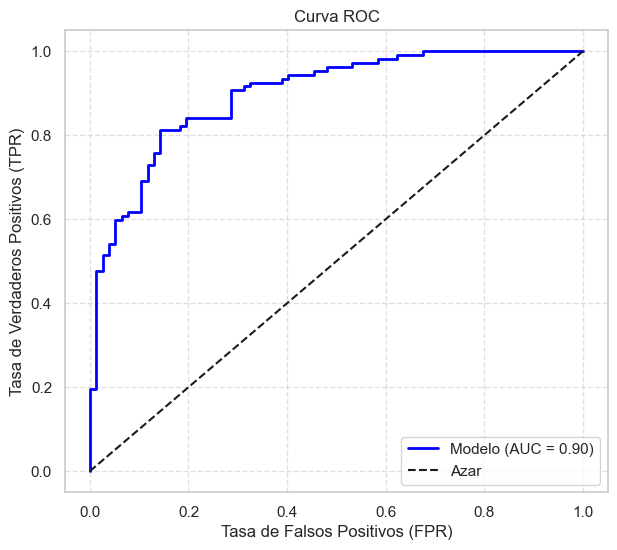

In [ ]:
graficar_curva_roc(mejor_modelo_lr, X_test, y_test)

In [ ]:
mejor_modelo_knn = grid_knn.best_estimator_
resultados_knn = evaluar_modelo(mejor_modelo_knn, X_test, y_test)
for metrica, valor in resultados_knn.items():
    print(f"{metrica}: \n{valor}\n")

Accuracy: 
0.7934782608695652

Precision: 
0.7948717948717948

Recall: 
0.8691588785046729

F1-score: 
0.8303571428571429

ROC-AUC: 
0.8554436217987621

Confusion Matrix: 
[[53 24]
 [14 93]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.79      0.69      0.74        77
           1       0.79      0.87      0.83       107

    accuracy                           0.79       184
   macro avg       0.79      0.78      0.78       184
weighted avg       0.79      0.79      0.79       184




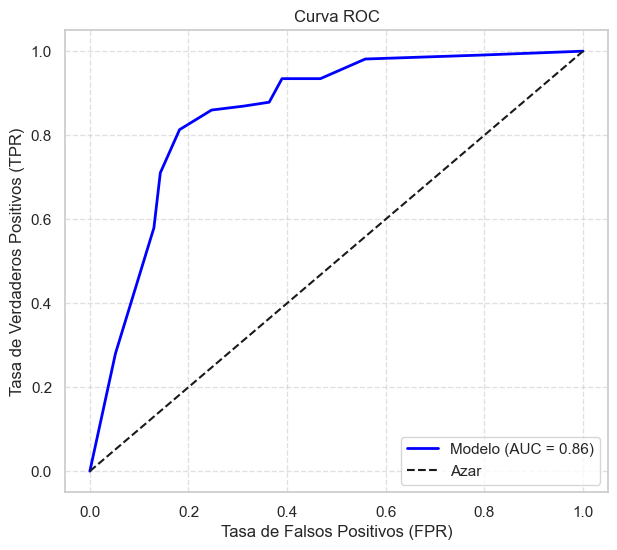

In [ ]:
graficar_curva_roc(mejor_modelo_knn, X_test, y_test)

In [ ]:
mejor_modelo_ridge = grid_ridge.best_estimator_
resultados_ridge = evaluar_modelo(mejor_modelo_ridge, X_test, y_test)
for metrica, valor in resultados_ridge.items():
    print(f"{metrica}: \n{valor}\n")

Accuracy: 
0.8152173913043478

Precision: 
0.811965811965812

Recall: 
0.8878504672897196

F1-score: 
0.8482142857142857

ROC-AUC: 
0.8975603835416919

Confusion Matrix: 
[[55 22]
 [12 95]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.71      0.76        77
           1       0.81      0.89      0.85       107

    accuracy                           0.82       184
   macro avg       0.82      0.80      0.81       184
weighted avg       0.82      0.82      0.81       184




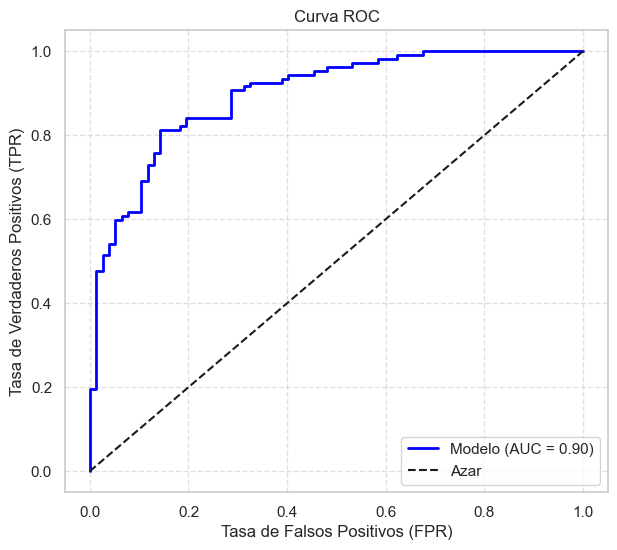

In [ ]:
graficar_curva_roc(mejor_modelo_ridge, X_test, y_test)

In [ ]:
mejor_modelo_lasso = grid_lasso.best_estimator_
resultados_lasso = evaluar_modelo(mejor_modelo_lasso, X_test, y_test)
for metrica, valor in resultados_lasso.items():
    print(f"{metrica}: \n{valor}\n")

Accuracy: 
0.8152173913043478

Precision: 
0.811965811965812

Recall: 
0.8878504672897196

F1-score: 
0.8482142857142857

ROC-AUC: 
0.8995023667920864

Confusion Matrix: 
[[55 22]
 [12 95]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.71      0.76        77
           1       0.81      0.89      0.85       107

    accuracy                           0.82       184
   macro avg       0.82      0.80      0.81       184
weighted avg       0.82      0.82      0.81       184




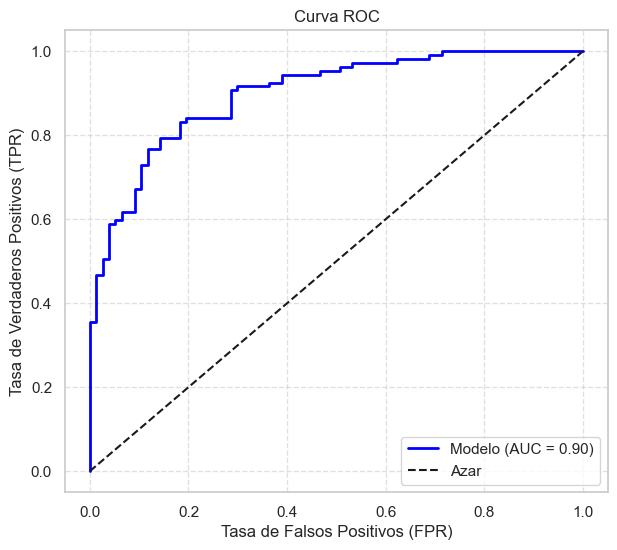

In [ ]:
graficar_curva_roc(mejor_modelo_lasso, X_test, y_test)

In [ ]:
mejor_modelo_bayes = grid_Bayes.best_estimator_
resultados_bayes = evaluar_modelo(mejor_modelo_bayes, X_test, y_test)
for metrica, valor in resultados_bayes.items():
    print(f"{metrica}: \n{valor}\n")

Accuracy: 
0.8097826086956522

Precision: 
0.8157894736842105

Recall: 
0.8691588785046729

F1-score: 
0.8416289592760181

ROC-AUC: 
0.8913703119310595

Confusion Matrix: 
[[56 21]
 [14 93]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        77
           1       0.82      0.87      0.84       107

    accuracy                           0.81       184
   macro avg       0.81      0.80      0.80       184
weighted avg       0.81      0.81      0.81       184




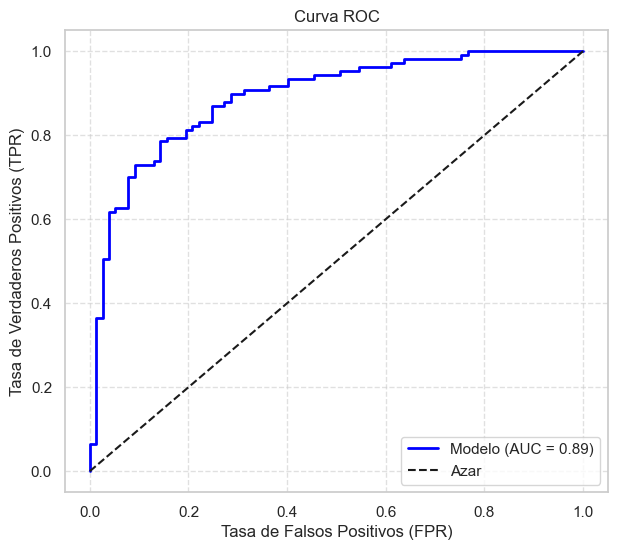

In [ ]:
graficar_curva_roc(mejor_modelo_bayes, X_test, y_test)

In [ ]:
mejor_modelo_RF = grid_RF.best_estimator_
resultados_RandomForest = evaluar_modelo(mejor_modelo_RF, X_test, y_test)
for metrica, valor in resultados_RandomForest.items():
    print(f"{metrica}: \n{valor}\n")

Accuracy: 
0.7934782608695652

Precision: 
0.8165137614678899

Recall: 
0.8317757009345794

F1-score: 
0.8240740740740741

ROC-AUC: 
0.8887000849617672

Confusion Matrix: 
[[57 20]
 [18 89]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.76      0.74      0.75        77
           1       0.82      0.83      0.82       107

    accuracy                           0.79       184
   macro avg       0.79      0.79      0.79       184
weighted avg       0.79      0.79      0.79       184




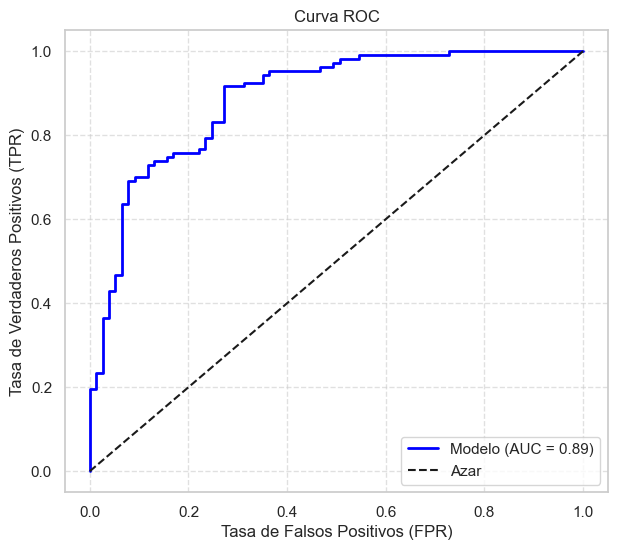

In [ ]:
graficar_curva_roc(mejor_modelo_RF, X_test, y_test)

In [ ]:
mejor_modelo_GBoost = grid_gr.best_estimator_
resultados_GBoost = evaluar_modelo(mejor_modelo_GBoost, X_test, y_test)
for metrica, valor in resultados_GBoost.items():
    print(f"{metrica}: \n{valor}\n")

Accuracy: 
0.8478260869565217

Precision: 
0.8558558558558559

Recall: 
0.8878504672897196

F1-score: 
0.8715596330275229

ROC-AUC: 
0.9058138123558683

Confusion Matrix: 
[[61 16]
 [12 95]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.79      0.81        77
           1       0.86      0.89      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.84       184
weighted avg       0.85      0.85      0.85       184




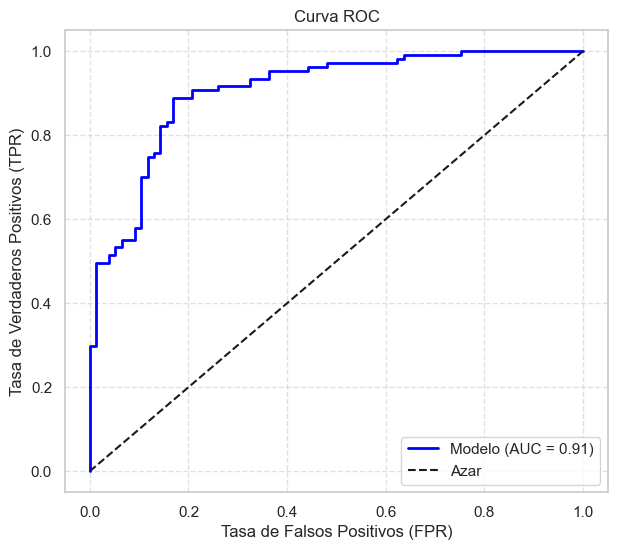

In [ ]:
graficar_curva_roc(mejor_modelo_GBoost, X_test, y_test)

In [ ]:
mejor_modelo_XGBoost = grid_xg.best_estimator_
resultados_XGBoost = evaluar_modelo(mejor_modelo_XGBoost, X_test, y_test)
for metrica, valor in resultados_XGBoost.items():
    print(f"{metrica}: \n{valor}\n")

Accuracy: 
0.8532608695652174

Precision: 
0.8508771929824561

Recall: 
0.9065420560747663

F1-score: 
0.8778280542986425

ROC-AUC: 
0.9086054132783105

Confusion Matrix: 
[[60 17]
 [10 97]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.78      0.82        77
           1       0.85      0.91      0.88       107

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.85       184
weighted avg       0.85      0.85      0.85       184




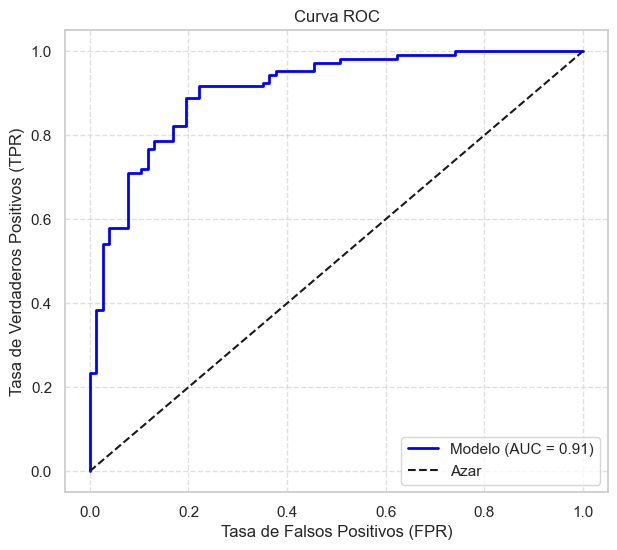

In [ ]:
graficar_curva_roc(mejor_modelo_XGBoost, X_test, y_test)

# Analisis de Resultados 

Podemos observar que de los modelos utilizados el de KNN tuvo scores mas bajos en comparacion con el resto de modelos aunque la mayoria tuvo resultados muy parecidos en cuanto a los Scores de manera general, los que tuvieron mejores scores fueron GradientBoosting y XGBoost, con XGBoost teniendo scores relativamente mejores 

In [ ]:
import joblib
joblib.dump(grid_xg.best_estimator_, "C:/Documentos/heart-desease-mlops/model.joblib")

['C:/Documentos/heart-desease-mlops/model.joblib']